----------------------------
# **Creación del Modelo y Evalución**
------------------------ 

-------------------
------------------
## **1.** **Importar Librerias**
-------------------
------------------

In [34]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

-------------------
------------------
## **2.** **Cargar Datos Procesados**
-------------------
------------------

In [35]:
# Load Processed Data
movies_path = '../Data/Processed/processed_movies.csv'
movies = pd.read_csv(movies_path)

-------------------
------------------
## **3.** **Preprocesamiento de Emociones**
-------------------
------------------

In [36]:
movies['emotions_str'] = movies['emotions'].apply(lambda x: ' '.join(eval(x)))

# Vectorize the emotions with TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['emotions_str'])

# Adjust n_components to a value less than or equal to n_features
n_features = tfidf_matrix.shape[1]
n_components = min(20, n_features)

# Apply dimensionality reduction with TruncatedSVD
svd = TruncatedSVD(n_components=n_components)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Compute cosine similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix_reduced, tfidf_matrix_reduced)

# Create a DataFrame to store the movies and their binarized emotions
mlb = MultiLabelBinarizer()
movies['emotions_list'] = movies['emotions'].apply(lambda x: eval(x))
emotions_binarized = mlb.fit_transform(movies['emotions_list'])

-------------------
------------------
## **4.** **Dividir los datos en entrenamiento y prueba**
-------------------
------------------

In [37]:
X_train, X_test, y_train, y_test = train_test_split(emotions_binarized, movies['average_rating'], test_size=0.2, random_state=42)

-------------------
------------------
## **5.** **Definir el Modelo**
-------------------
------------------

In [38]:
# Define the model
input_layer = Input(shape=(emotions_binarized.shape[1],))
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

-------------------
------------------
## **6.** **Entrenamiento del Modelo**
-------------------
------------------

In [39]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 2.7043 - mae: 0.8760 - val_loss: 0.6005 - val_mae: 0.4962
Epoch 2/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6815 - mae: 0.5749 - val_loss: 0.4417 - val_mae: 0.4804
Epoch 3/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5498 - mae: 0.5521 - val_loss: 0.4174 - val_mae: 0.4849
Epoch 4/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.5170 - mae: 0.5421 - val_loss: 0.4177 - val_mae: 0.4903
Epoch 5/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4900 - mae: 0.5313 - val_loss: 0.4075 - val_mae: 0.4765
Epoch 6/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4904 - mae: 0.5307 - val_loss: 0.4069 - val_mae: 0.4707
Epoch 7/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4790 - mae: 0.5234 - val_loss: 0.4090 - val_mae: 0.4688
Epoch 8/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.4784 - mae: 0.5209 - val_loss: 0.4163 - val_mae: 0.4904
Epoch 9/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 8s 11m

-------------------
------------------
## **7.** **Guardar el Modelo**
-------------------
------------------

In [40]:
model.save('../Models/movie_recommender_model.keras')

-------------------
------------------
## **8.** **Visualizar el Proceso de Entrenamiento**
-------------------
------------------

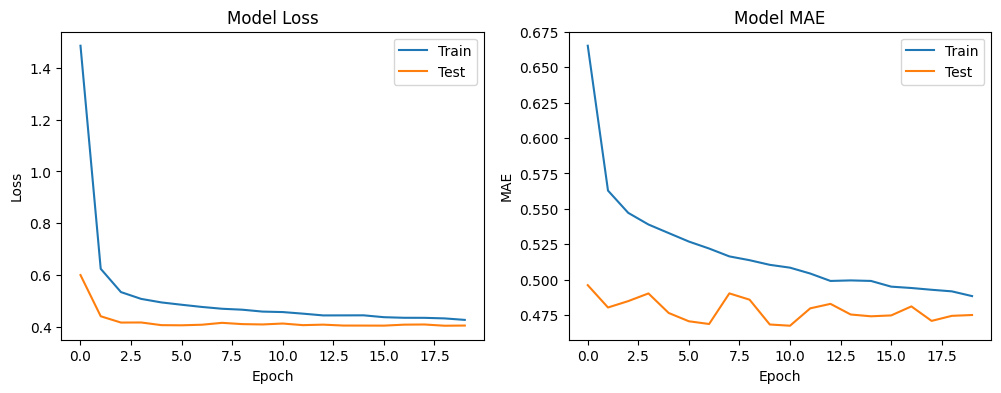

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()


-------------------
------------------
## **9.** **Evaluación del Modelo**
-------------------
------------------

In [42]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}, Model MAE: {mae}')

# Calculate the mean value of y_test
y_test_mean = np.mean(y_test)

# Convert the loss to a percentage of the mean value of y_test
loss_percentage = (loss / y_test_mean) * 100

# Convert the MAE to a percentage of the mean value of y_test
mae_percentage = (mae / y_test_mean) * 100

print(f'Model Loss: {loss} ({loss_percentage:.2f}%)')
print(f'Model MAE: {mae} ({mae_percentage:.2f}%)')

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3952 - mae: 0.4697
Model Loss: 0.4058927893638611, Model MAE: 0.4750940799713135
Model Loss: 0.4058927893638611 (12.90%)
Model MAE: 0.4750940799713135 (15.10%)


-------------------
------------------
## **10.** **Función de Recomendación**
-------------------
------------------

In [43]:
def recommend_movies_nn(emotion1, emotion2, movies=movies, mlb=mlb, model=model, top_n=10):
    emotions = [emotion1, emotion2]
    binarized_emotions = mlb.transform([emotions])
    predicted_rating = model.predict(binarized_emotions)[0][0]
    
    # Find movies with ratings close to the prediction
    movies['rating_diff'] = abs(movies['average_rating'] - predicted_rating)
    recommended_movies = movies.sort_values(by=['rating_diff', 'average_rating'], ascending=[True, False]).head(top_n)
    
    return recommended_movies[['title', 'average_rating']]

# Example recommendation
print("Recomendaciones para las emociones 'Joy' y 'Fear':")
print(recommend_movies_nn('Joy', 'Fear'))

Recomendaciones para las emociones 'Joy' y 'Fear':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
                                                   title  average_rating
3666                                       Asylum (1972)        2.921687
19165                                Rock of Ages (2012)        2.921687
14491  Teenage Mutant Ninja Turtles: Turtles Forever ...        2.921429
13077                                 Fifty Pills (2006)        2.921875
14514                 Torrente 2: Misión Marbella (2001)        2.921875
2036                               Needful Things (1993)        2.921069
3520                               Saludos Amigos (1943)        2.921053
5362   Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...        2.922229
6231                                People I Know (2002)        2.920833
4558                Return of the Musketeers, The (1989)        2.922330
